__Abgabe 3: Lösen der Poissongleichung in 2D__

Die Poissongleichung fuer den Navier-Stokes Löser lautet:

$$
\nabla^2 p=\nabla \cdot(\vec{u} \cdot \nabla \vec{u})
$$

oder

$$
\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2}=f
$$

mit 

$$
f=\frac{\partial}{\partial x}\left(u \frac{\partial u}{\partial x}+v \frac{\partial u}{\partial y}\right)+\frac{\partial}{\partial y}\left(u \frac{\partial v}{\partial x}+v \frac{\partial v}{\partial y}\right)
$$

__Aufgabe 1__

Entwickeln Sie einen Löser für die Druck-Poisson-Gleichung für verschiedene numerische Methoden mit periodischen Randbedingungen. Testen Sie Ihren Löser mit dem Taylor-Green-Vortex, für den eine exakte Lösung der Navier-Stokes-Gleichungen in 2D bekannt ist. Visualisieren Sie Ihre Ergebnisse. 

$$
\begin{gathered}
u(x, y, t)=e^{-\frac{2}{R e} t} \sin (x) \cos (y) \\
v(x, y, t)=-e^{-\frac{2}{R e} t} \cos (x) \sin (y)
\end{gathered}
$$

a) Verwenden Sie das Jacobi-Verfahren.

b) Verwenden Sie das Gauss-Seidel-Verfahren.

c) Verwenden Sie das Successive Over-Relaxation (SOR)-Verfahren. Testen Sie verschiedene Relaxationsfaktoren _w_. Was passiert wenn _w_ grösser oder kleiner als 1 wird?

__Aufgabe 2__

Eingesetzt in die Navier-Stokes-Gleichungen ergibt sich für den Druck die analytische Lösung 

$$
p(x, y, t)=\frac{1}{4} e^{-\frac{4}{R e} t}[\cos (2 x)+\cos (2 y)]
$$

Visualisieren Sie die Konvergenz der verschiedenen Methoden (Jacobi, Gauss-Seidel, SOR mit verschiedenen _w_), indem Sie die $L_2 \ $-Fehlernorm über der Anzahl der Iterationen auftragen. Untersuchen Sie auch die Zeit und die Anzahl der Iterationen bis zur Konvergenz. Definieren Sie dazu eine ausreichend kleine Fehlerabweichung $||
\varepsilon||_2$, unterhalb derer Sie die Lösung als konvergiert betrachten.

In [1]:
using Plots; gr()
using LaTeXStrings
using Printf
using LinearAlgebra

__Setup der Domain und Anfangsbedingungen__

In [2]:
# Problem parameters
nx, ny = 101, 101  # Number of grid points in x and y
Lx, Ly = 2pi, 2pi  # Domain length in x and y
dx, dy = Lx / (nx-1), Ly / (ny-1)  # Grid spacing
max_iter = 6000  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance
x = (0:nx-1) * dx
y = (0:ny-1) * dy

# Initial conditions
p = zeros(nx, ny)  # Initial guess for pressure
rhs = zeros(nx, ny)  # Right-hand side of the Poisson equation

# Taylor-Green Vortex parameters
Re = 1600.0  # Reynolds number
u = zeros(nx, ny)  # Velocity field in x
v = zeros(nx, ny)  # Velocity field in y
t = 0  # Start time
dt = 0.01 # time step size

0.01

__Funktion zur Berechnung des Taylor Green Vortex__

In [3]:
# Initialize Taylor-Green Vortex
function u_v_calculation(t)
    for j in 1:ny
        for i in 1:nx
            x = (i-1) * dx
            y = (j-1) * dy
            u[i, j] = exp(-2 * t / Re) * sin(x) * cos(y)
            v[i, j] = -exp(-2 * t / Re) * cos(x) * sin(y)
        end
    end
    return u, v
end

u_v_calculation (generic function with 1 method)

__Hilfsfunktionen zum Plotten__

In [4]:
function heatgif(p_solution, used_method)
    n = length(p_solution)
    @gif for i in 1:n
        heatmap(x, y, p_solution[i], size=(400, 400), title="Pressure Field - $used_method", xlabel="x", ylabel="y")
    end
end

heatgif (generic function with 1 method)

__Hilfsfunktion zum Berechnen der L2 Norm__

In [5]:
# Function to compute an error in L2 norm
function l2_err(u1, u2)
    return sqrt(sum((u1 .- u2).^2))
end

l2_err (generic function with 1 method)

### Aufgabe 1

__Funktion zur Behandlung verschiedener Arten von Randbedingungen__

In [6]:
# Calculate rhs
function rhs_calculation(t)
    u, v = u_v_calculation(t)
    ∂u_∂x = zeros(nx, ny)
    ∂u_∂y = zeros(nx, ny)
    ∂v_∂x = zeros(nx, ny)
    ∂v_∂y = zeros(nx, ny)
    
    # Calculate partial derivatives using central differences
    for i in 2:nx-1
        for j in 2:ny-1
            ∂u_∂x[i, j] = (u[i+1, j] - u[i-1, j]) / (2dx)
            ∂u_∂y[i, j] = (u[i, j+1] - u[i, j-1]) / (2dy)
            ∂v_∂x[i, j] = (v[i+1, j] - v[i-1, j]) / (2dx)
            ∂v_∂y[i, j] = (v[i, j+1] - v[i, j-1]) / (2dy)
        end
    end

    # Intermediate terms
    u_∂u_∂x = u .* ∂u_∂x
    v_∂u_∂y = v .* ∂u_∂y
    u_∂v_∂x = u .* ∂v_∂x
    v_∂v_∂y = v .* ∂v_∂y

    # Divergence terms
    ∂_∂x = zeros(nx, ny)
    ∂_∂y = zeros(nx, ny)

    for i in 2:nx-1
        for j in 2:ny-1
            ∂_∂x[i, j] = (u_∂u_∂x[i+1, j] + v_∂u_∂y[i+1, j] - u_∂u_∂x[i-1, j] - v_∂u_∂y[i-1, j]) / (2dx)
            ∂_∂y[i, j] = (u_∂v_∂x[i, j+1] + v_∂v_∂y[i, j+1] - u_∂v_∂x[i, j-1] - v_∂v_∂y[i, j-1]) / (2dy)
        end
    end
    rhs = ∂_∂x + ∂_∂y
    return -rhs
end


rhs_calculation (generic function with 1 method)

__Funktionen für die iterativen Solver__

__Jacobi__

In [7]:
# Function to update the pressure field using the Jacobi method
function jacobi_step(p_old, t)
    rhs = rhs_calculation(t)
    p_new = copy(p_old)

    # inner points
    for j in 2:ny-1
        for i in 2:nx-1
            p_new[i, j] = 0.25 * (p_old[i+1, j] + p_old[i-1, j] + p_old[i, j+1] + p_old[i, j-1] - dx^2 * rhs[i, j])
        end         
    end

    # Apply periodic boundary conditions
    for i in 2:nx-1
        p_new[i, 1] = 0.25 * (p_old[i+1, 1] + p_old[i-1, 1] + p_old[i, 2] + p_old[i, ny-1] - dx^2 * rhs[i, 1])
        p_new[i, ny] = p_new[i, 1]  # Top boundary wraps around to bottom

        p_new[1, i] = 0.25 * (p_old[2, i] + p_old[nx-1, i] + p_old[1, i+1] + p_old[1, i-1] - dx^2 * rhs[1, i])
        p_new[nx, i] = p_new[1, i]  # Right boundary wraps around to left
    end

    # Corners
    p_new[1, 1] = 0.25 * (p_old[2, 1] + p_old[nx-1, 1] + p_old[1, 2] + p_old[1, ny-1] - dx^2 * rhs[1, 1])
    p_new[nx, 1] = p_new[1, 1]  # Bottom-left corner wraps around to top-left
    p_new[1, ny] = p_new[1, 1]  # Top-right corner wraps around to top-left
    p_new[nx, ny] = p_new[1, 1]  # Bottom-right corner wraps around to top-left

    return p_new
end

# Jacobi solver
function jacobi_solver(p_initial, max_iter, tol)
    p_all = Vector{Array{Float64, 2}}()
    residual = Vector{Float64}()
    t = 0
    p_old = copy(p_initial)
    p_new = copy(p_initial)

    elapsed_time = @elapsed begin
        for iter in 1:max_iter
            p_new = jacobi_step(p_old, t)
            push!(p_all, copy(p_new))

            # Check for convergence
            if maximum(abs.(p_new .- p_old)) < tol
                println("Converged in $iter iterations")
                break
            end

            # Update pressure field for the next iteration
            p_old .= p_new  # Use in-place update
            t += dt
        end
        println("Reached maximum iterations without convergence - Jacobi")
    end
    
    return p_all, length(p_all), elapsed_time
end

jacobi_solver (generic function with 1 method)

__Gauss-Seidel__

In [8]:
# Function to update the pressure field using the Gauss Seidel method
function gauss_seidel_step(p_old, t)
    rhs = rhs_calculation(t)
    p_new = copy(p_old)

    # inner points
    for j in 2:ny-1
        for i in 2:nx-1
            p_new[i, j] = 0.25 * (p_new[i-1, j] + p_old[i+1, j] + p_new[i, j-1] + p_old[i, j+1] - dx^2 * rhs[i, j])
        end
    end
    
    # Apply periodic boundary conditions
    for i in 2:nx-1
        p_new[i, 1] = 0.25 * (p_old[i+1, 1] + p_new[i-1, 1] + p_old[i, 2] + p_new[i, ny-1] - dx^2 * rhs[i, 1])
        p_new[i, ny] = p_new[i, 1]  # Top boundary wraps around to bottom

        p_new[1, i] = 0.25 * (p_old[2, i] + p_new[nx-1, i] + p_old[1, i+1] + p_new[1, i-1] - dx^2 * rhs[1, i])
        p_new[nx, i] = p_new[1, i]  # Right boundary wraps around to left
    end

    # Corners
    p_new[1, 1] = 0.25 * (p_old[2, 1] + p_new[nx-1, 1] + p_old[1, 2] + p_new[1, ny-1] - dx^2 * rhs[1, 1])
    p_new[nx, 1] = p_new[1, 1]  # Bottom-left corner wraps around to top-left
    p_new[1, ny] = p_new[1, 1]  # Top-right corner wraps around to top-left
    p_new[nx, ny] = p_new[1, 1]  # Bottom-right corner wraps around to top-left

    return p_new
end

# Jacobi solver
function gauss_seidel_solver(p_initial, max_iter, tol)
    p_all = Vector{Array{Float64, 2}}()
    t = 0
    p_old = copy(p_initial)
    p_new = copy(p_initial)

    elapsed_time = @elapsed begin
        for iter in 1:max_iter
            p_new = gauss_seidel_step(p_old, t)
            push!(p_all, copy(p_new))

            # Check for convergence
            residual_temp = maximum(abs.(p_new .- p_old))
            if residual_temp < tol
                println("Converged in $iter iterations")
                break
            end

            # Update pressure field for the next iteration
            p_old .= p_new  # Use in-place update
            t += dt
        end
        println("Reached maximum iterations without convergence - Gauss Seidel")
    end
    return p_all, length(p_all), elapsed_time
end

gauss_seidel_solver (generic function with 1 method)

__Successive Over-Relaxation (SOR)__

In [9]:
# SOR (Successive Over Relaxation) method
function sor_step(p_old, t, w)
    rhs = rhs_calculation(t)
    p_new = copy(p_old)
    p_gauss = zeros(nx, ny)

    # inner points
    for j in 2:ny-1
        for i in 2:nx-1
            p_gauss[i, j] = 0.25 * (p_new[i-1, j] + p_old[i+1, j] + p_new[i, j-1] + p_old[i, j+1] - dx^2 * rhs[i, j])
            p_new[i, j] = p_old[i, j] + w * (p_gauss[i, j] - p_old[i, j])
        end
    end

    # Apply periodic boundary conditions
    for i in 2:nx-1
        p_gauss[i, 1] = 0.25 * (p_old[i+1, 1] + p_new[i-1, 1] + p_old[i, 2] + p_new[i, ny-1] - dx^2 * rhs[i, 1])
        p_new[i, 1] = p_old[i, 1] + w * (p_gauss[i, 1] - p_old[i, 1])
        p_new[i, ny] = p_new[i, 1]  # Top boundary wraps around to bottom

        p_gauss[1, i] = 0.25 * (p_old[2, i] + p_new[nx-1, i] + p_old[1, i+1] + p_new[1, i-1] - dx^2 * rhs[1, i])
        p_new[1, i] = p_old[1, i] + w * (p_gauss[1, i] - p_old[1, i])
        p_new[nx, i] = p_new[1, i]  # Right boundary wraps around to left
    end

    # Corners
    p_gauss[1, 1] = 0.25 * (p_old[2, 1] + p_new[nx-1, 1] + p_old[1, 2] + p_new[1, ny-1] - dx^2 * rhs[1, 1])
    p_new[1, 1] = p_old[1, 1] + w * (p_gauss[1, 1] - p_old[1, 1])
    p_new[nx, 1] = p_new[1, 1]  # Bottom-left corner wraps around to top-left
    p_new[1, ny] = p_new[1, 1]  # Top-right corner wraps around to top-left
    p_new[nx, ny] = p_new[1, 1]  # Bottom-right corner wraps around to top-left
    return p_new
end

function sor_solver(p_initial, max_iter, tol, w)
    p_all = Vector{Array{Float64, 2}}()
    t = 0
    p_old = copy(p_initial)
    p_new = copy(p_initial)

    elapsed_time = @elapsed begin
        for iter in 1:max_iter
            p_new = sor_step(p_old, t, w)
            push!(p_all, copy(p_new))

            # Check for convergence
            if maximum(abs.(p_new .- p_old)) < tol
                println("Converged in $iter iterations")
                break
            end

            # Update pressure field for the next iteration
            p_old .= p_new  # Use in-place update
            t += dt
        end
        println("Reached maximum iterations without convergence - SOR")
    end
    return p_all, length(p_all), elapsed_time
end

sor_solver (generic function with 1 method)

### Aufgabe 2

__Analytische Lösung__

In [10]:
function p_analytical(t=0)
    exp_term = exp(-4 * t / Re)
    p = zeros(nx, ny)
    for i in 1:length(x)
        for j in 1:length(y)
            p[i, j] = 1/4 * exp_term * (cos(2 * x[i]) + cos(2 * y[j]))
        end
    end
    return p
end


p_analytical (generic function with 2 methods)

__Berechnen der Fehlernorm für die verschiedenen Verfahren__

In [11]:
function calculate_L2_error(p_analytical, p_numerical)
    num_iterations = length(p_numerical)
    errors_all = zeros(num_iterations)

    # Compute the L2 error
    for i in 1:num_iterations
        errors_all[i] = sqrt(sum((p_numerical[i] .- p_analytical).^2))
    end

    return errors_all
end

calculate_L2_error (generic function with 1 method)

__Konvergenz-Plot: Fehlernorm über Iterationen__

In [12]:
function plot_l2_error(error_vectors, labels)
    plot()
    for (i, errors) in enumerate(error_vectors)
        iterations = 1:length(errors)
        plot!(iterations, errors, label=labels[i])
    end
    xlabel!("Iteration")
    ylabel!("L2 Error")
    title!("L2 Error over Iterations for Different Methods")
    plot!(legend=:topright)
end

plot_l2_error (generic function with 1 method)

__Ausgabe der Rechenzeiten und Anzahl der Iterationen__

Converged in 769 iterations
Reached maximum iterations without convergence - Jacobi
The Jacobi solver took 15.7838842 seconds and 769 iterations to converge.


┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_P0l23ClYZ4.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_P0l23ClYZ4.gif")
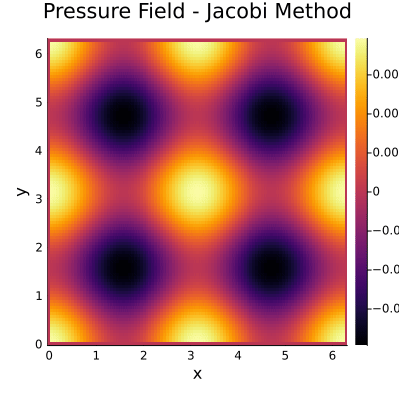

In [13]:
# Solve the Poisson equation using the Jacobi method
p_numerical_jacobi, iterations_jacobi, computing_time_jacobi = jacobi_solver(p, max_iter, tol)
println("The Jacobi solver took $computing_time_jacobi seconds and $iterations_jacobi iterations to converge.")

heatgif(p_numerical_jacobi, "Jacobi Method")

Converged in 515 iterations
Reached maximum iterations without convergence - Gauss Seidel
The Gauss Seidel solver took 9.5767487 seconds and 515 iterations to converge.


┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_zK1Ml23EXs.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_zK1Ml23EXs.gif")
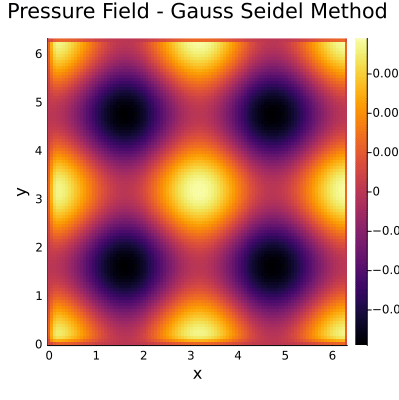

In [14]:
# Solve the Poisson equation using the Gauss Seidel method
p_numerical_gauss, iterations_gauss, computing_time_gauss = gauss_seidel_solver(p, max_iter, tol)
println("The Gauss Seidel solver took $computing_time_gauss seconds and $iterations_gauss iterations to converge.")

heatgif(p_numerical_gauss, "Gauss Seidel Method")

Converged in 392 iterations
Reached maximum iterations without convergence - SOR
The SOR solver took 8.1101329 seconds and 392 iterations to converge.


┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_Ho9u3iLElQ.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_Ho9u3iLElQ.gif")
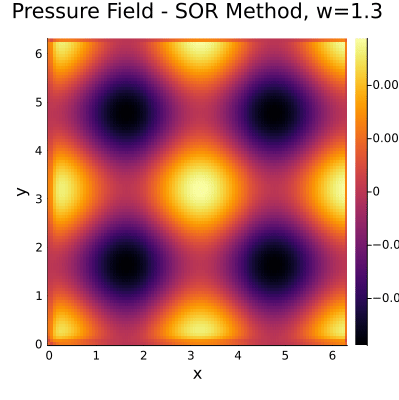

In [15]:
# Solve the Poisson equation using the SOR method
w_1 = 1.3
p_numerical_sor_1, iterations_sor_1, computing_time_sor_1 = sor_solver(p, max_iter, tol, w_1)
println("The SOR solver took $computing_time_sor_1 seconds and $iterations_sor_1 iterations to converge.")

heatgif(p_numerical_sor_1, "SOR Method, w=$w_1")

Converged in 742 iterations
Reached maximum iterations without convergence - SOR
The SOR solver took 15.6246664 seconds and 742 iterations to converge.


┌ Info: Saved animation to C:\Users\pbreu\AppData\Local\Temp\jl_pqLaJyBkFS.gif
└ @ Plots C:\Users\pbreu\.julia\packages\Plots\ju9dp\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\pbreu\\AppData\\Local\\Temp\\jl_pqLaJyBkFS.gif")
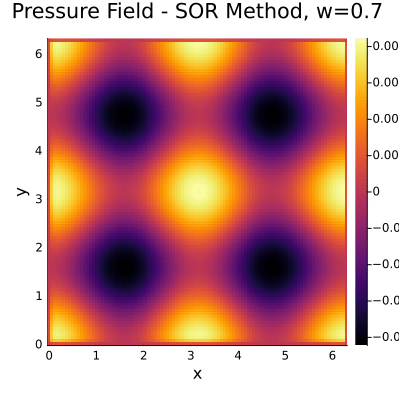

In [16]:
# Solve the Poisson equation using the SOR method
w_2 = 0.7
p_numerical_sor_2, iterations_sor_2, computing_time_sor_2 = sor_solver(p, max_iter, tol, w_2)
println("The SOR solver took $computing_time_sor_2 seconds and $iterations_sor_2 iterations to converge.")

heatgif(p_numerical_sor_2, "SOR Method, w=$w_2")

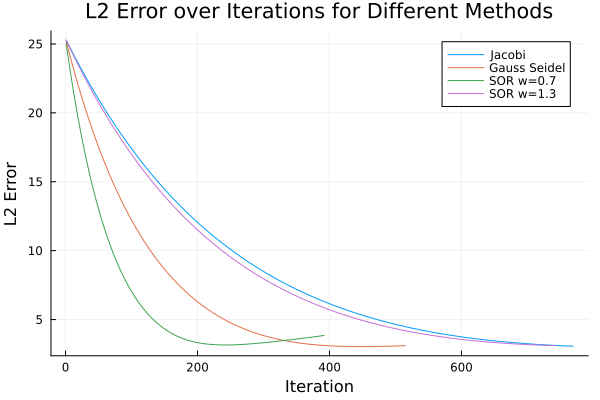

In [17]:
p_analytic = p_analytical()
jacobi_l2_error = calculate_L2_error(p_analytic, p_numerical_jacobi)
gauss_l2_error = calculate_L2_error(p_analytic, p_numerical_gauss)
sor_1_l2_error = calculate_L2_error(p_analytic, p_numerical_sor_1)
sor_2_l2_error = calculate_L2_error(p_analytic, p_numerical_sor_2)
error_vector = [jacobi_l2_error, gauss_l2_error, sor_1_l2_error, sor_2_l2_error]
labels = ["Jacobi", "Gauss Seidel", "SOR w=0.7", "SOR w=1.3"]
plot_l2_error(error_vector, labels)

### Explanation of the code

First of all we declare some constants for our domain. like the length and the width.
Also the grid spacing and the number of nodes that are calculated are beeing specified, as well as the parameters for the Taylor-Green Vortex.

Calculation of u and v:
- The function calculates the velocity fields u and v for the given time t and returns them.

Heatgif:
- The function creates a heatmap for the every time step so that we can see the development.

L2 error:
- This function i used for testing the convergence of all methods within the solver.
- U will see also in my plots for the l2 error against the analytical solution, that the l2 error didn't work for me.
- Maybe why this is the case, i will go over later.

RHS calculation:
- Here we calculate the rhs f and return them. 
- I return -rhs because in the assignment firstly there was a mistake with the sign.

Solver in general:
- For every method the structure is the same:
- I have a step function that calculates the solution for the next step. This is why we need to pass the old time step and the time as inputs.
- The actual solver starts the time counting and iterates over the max iterations. Every step gets stored and if the convergence is reached we break out of the loop.
- Inside of the interation loop we then call the step function for the actual calculation.
- We return the solution of every step, the number of iterations and the calculation time. Lastly doesn't make really sense but i don't know really why.

The last functions calculate the analytical solution and the l2 error between the numerical and analytical solution for each time step.
Lastly the errors of all methods are getting plotted.

Boundary Condition and problems:
- My guess for the problems i have are the boundary conditions. I calculate them this way:
    For the points on the left boundary i have no point that is further left so i use the point that is left next to the point on the right boundary. This way i ensure that the points on the left and right boundary are the same and we have periodic conditions.
    The same i do for the upper and lower boundarys as well as the corners.
    In the heatmaps we can see, that the solution is quite accurate in general, so the l2 error should be at least below 1. The only option is then the boundary.

What works, despite the L2 error problem:
- Looking at the number of iterations and the solution on the heatmap, the solvers work. (for the inner points...)
- SOR: For w>1 the solver takes less iterations, because the updates are bigger and more aggressive. The solution progresses faster. (Over-Relaxation)
- SOR: For w<1 the solver takes more iterations, because the updates are smaller. (Under-Relaxation)

Note: After the lecture on 19th of June I am sure, that I implemented the boundarys the wrong way. Sadly i couldn't change and get it to work on the last day of the submission...